In [30]:
import torch

# Check if CUDA is available
device = torch.device("mps" )
print(f"Using device: {device}")

Using device: mps


In [31]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

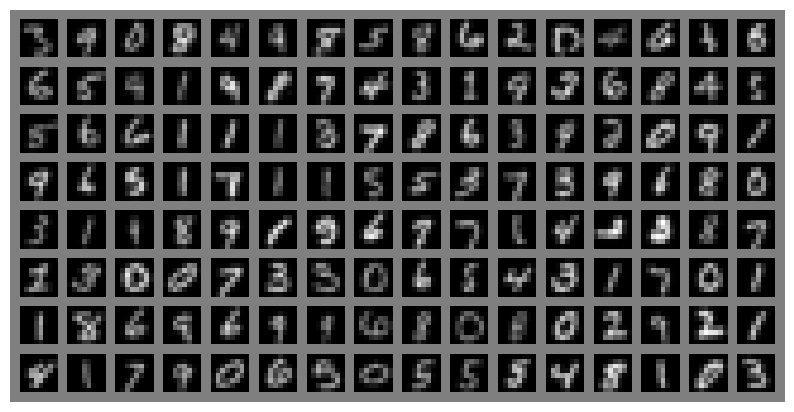

In [32]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of training data
images, labels = next(iter(train_loader))

# Create a grid of images
img_grid = vutils.make_grid(images, nrow=16, normalize=True, pad_value=0.5)

# Convert the grid to a numpy array and change the order of dimensions for matplotlib
img_grid = img_grid.numpy().transpose((1, 2, 0))

# Plot the grid of images
plt.figure(figsize=(10, 10))
plt.imshow(img_grid)
plt.axis('off')
plt.show()

Epoch 1/25, Loss: 0.0016682465793564916
Epoch 2/25, Loss: 0.0035630101338028908
Epoch 3/25, Loss: 0.009302003309130669
Epoch 4/25, Loss: 0.010372044518589973
Epoch 5/25, Loss: 0.009438090026378632
Epoch 6/25, Loss: 0.010808052495121956
Epoch 7/25, Loss: 0.016272470355033875
Epoch 8/25, Loss: 0.013989957980811596
Epoch 9/25, Loss: 0.016208451241254807
Epoch 10/25, Loss: 0.021399054676294327
Epoch 11/25, Loss: 0.015216748230159283
Epoch 12/25, Loss: 0.018997468054294586
Epoch 13/25, Loss: 0.012739038094878197
Epoch 14/25, Loss: 0.016341863200068474
Epoch 15/25, Loss: 0.014004011638462543
Epoch 16/25, Loss: 0.015292635187506676
Epoch 17/25, Loss: 0.021266113966703415
Epoch 18/25, Loss: 0.017359590157866478
Epoch 19/25, Loss: 0.016709906980395317
Epoch 20/25, Loss: 0.01869531348347664
Epoch 21/25, Loss: 0.018062125891447067
Epoch 22/25, Loss: 0.014116446487605572
Epoch 23/25, Loss: 0.013607781380414963
Epoch 24/25, Loss: 0.011460094712674618
Epoch 25/25, Loss: 0.012122469022870064


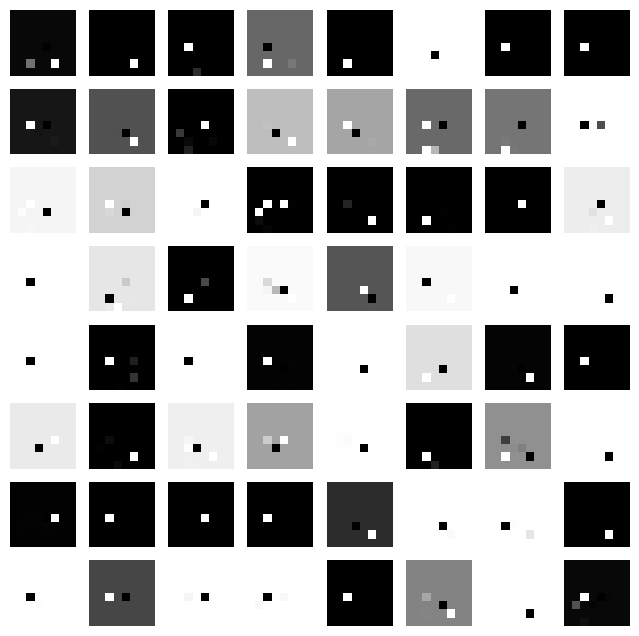

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

# Data Preprocessing
def preprocess_data():
    transform = T.Compose([T.ToTensor(), T.Resize((8, 8)), T.Normalize((0.5,), (0.5,))])
    train_data = MNIST(root='./data', train=True, download=True, transform=transform)
    test_data = MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)
    return train_loader, test_loader

class RealNVP(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=256, num_layers=32):
        super(RealNVP, self).__init__()
        self.num_layers = num_layers
        self.coupling_layers = nn.ModuleList([CouplingLayer(input_dim, hidden_dim) for _ in range(num_layers)])

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.coupling_layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.inverse(z)
        return z

class CouplingLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(CouplingLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim // 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim // 2)
        # Change the input dimension of fc3 to match the output of fc1 (hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim // 2)  

    def forward(self, x):
        x1, x2 = torch.chunk(x, 2, dim=1)
        h = torch.relu(self.fc1(x1))
        s = self.fc2(h)
        t = self.fc3(h)
        z2 = x2 * torch.exp(s) + t
        return torch.cat((x1, z2), dim=1), torch.sum(s, dim=1)  # log-det jacobian

    def inverse(self, z):
        z1, z2 = torch.chunk(z, 2, dim=1)
        h = torch.relu(self.fc1(z1))
        s = self.fc2(h)
        t = self.fc3(h)
        x2 = (z2 - t) / torch.exp(s)
        return torch.cat((z1, x2), dim=1)

class MAF(nn.Module):
    def __init__(self, input_dim=64, hidden_dim=128, num_layers=32):
        super(MAF, self).__init__()
        self.num_layers = num_layers
        self.layers = nn.ModuleList([MaskedAutoregressiveLayer(input_dim, hidden_dim) for _ in range(num_layers)])

    def forward(self, x):
        log_det_jacobian = 0
        for layer in self.layers:
            x, ldj = layer(x)
            log_det_jacobian += ldj
        return x, log_det_jacobian

    def inverse(self, z):
        for layer in reversed(self.layers):
            z = layer.inverse(z)
        return z

class MaskedAutoregressiveLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MaskedAutoregressiveLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)

        self.mask1 = self.create_mask(input_dim)
        self.mask2 = self.create_mask(input_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        h = h * self.mask1
        out = torch.sigmoid(self.fc2(h))
        out = out * self.mask2
        log_det_jacobian = torch.sum(torch.log(out), dim=1)
        return out, log_det_jacobian

    def inverse(self, z):
        h = torch.relu(self.fc1(z))
        h = h * self.mask1
        out = torch.sigmoid(self.fc2(h))
        out = out * self.mask2
        return out

    def create_mask(self, dim):
        mask = torch.zeros(dim, dim)
        mask = torch.tril(mask)  # Lower triangular mask for autoregressive flow
        return mask



def train_model(model, train_loader, epochs=25, lr=1e-3):
    model.to(device)  # Move model to MPS device
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Use MSE loss or log-likelihood for training
    
    for epoch in range(epochs):
        model.train()
        for data, _ in train_loader:
            data = data.to(device)  # Move data to MPS device
            data = data.view(data.size(0), -1)  # Flatten the images
            optimizer.zero_grad()
            output, _ = model(data)  # Unpack the output tuple 
            loss = criterion(output, data)  # Minimize the reconstruction error
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

# Sampling from the model (for generating synthetic images)
def sample_images(model, num_samples=64):
    model.eval()
    model.to(device)  # Move model to MPS device
    with torch.no_grad():
        z = torch.randn(num_samples, 64).to(device)  # Latent space sampling
        generated_images = model.inverse(z)
        generated_images = generated_images.view(num_samples, 1, 8, 8)
        return generated_images



# Log-likelihood evaluation (simplified example)
def evaluate_log_likelihood(model, test_loader):
    model.eval()
    total_ll = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(data.size(0), -1)
            log_prob = model(data)  # Assuming model returns log likelihood directly
            total_ll += log_prob.sum().item()
    avg_ll = total_ll / len(test_loader.dataset)
    return avg_ll

# Visualize generated images in grid
def plot_generated_images(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i in range(8):
        for j in range(8):
            axes[i, j].imshow(images[i*8+j].squeeze(), cmap='gray')
            axes[i, j].axis('off')
    plt.show()

train_loader, test_loader = preprocess_data()
realnvp_model = RealNVP(input_dim=64).to(device)
train_model(realnvp_model, train_loader)
realnvp_images = sample_images(realnvp_model)
plot_generated_images(realnvp_images.cpu()) 





In [ ]:
maf_model = MAF(input_dim=64).to(device)
train_model(maf_model, train_loader)
maf_images = sample_images(maf_model)
plot_generated_images(maf_images.cpu()) 